## Project: Stable sets for fair communications

Sabrina Dietrich

In [10]:
# Installation cell
%%capture
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget -q 'https://julialang-s3.julialang.org/bin/linux/x64/1.7/julia-1.7.2-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'
echo 'Done'

LoadError: syntax: "%" is not a unary operator

In [2]:
import Pkg

Pkg.add("JuMP")
Pkg.add("Random")
Pkg.add("Graphs")
Pkg.add("GraphPlot")
Pkg.add("Compose")
Pkg.add("Cairo")
Pkg.add("Combinatorics")
Pkg.add("Cbc")
Pkg.add("LightGraphs")
using GraphPlot, Compose, Cairo, Graphs, Combinatorics

    Updating registry at `C:\Users\sabri\.julia\registries\General`
┌ Warning: Some registries failed to update:
│     — `C:\Users\sabri\.julia\registries\General` — registry dirty
└ @ Pkg.Types C:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.6\Pkg\src\Types.jl:1246
   Resolving package versions...
  No Changes to `C:\Users\sabri\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\sabri\.julia\environments\v1.6\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\sabri\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\sabri\.julia\environments\v1.6\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\sabri\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\sabri\.julia\environments\v1.6\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\sabri\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\sabri\.julia\environments\v1.6\Manifest.toml`
   Resolving

In [3]:
using Plots, JuMP, Cbc, LightGraphs

To initiate solving the problem, we just generate random nodes with random edges between them.

**It is possible to define the number of nodes (n) below:** 

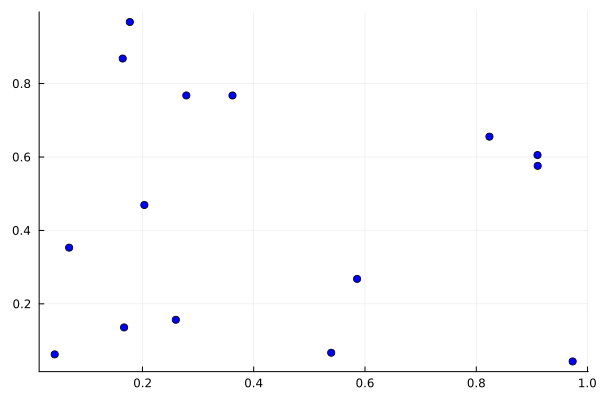

In [4]:
using LinearAlgebra, Random
Random.seed!(0)

# Define the number of nodes in the graph
n = 15

P = rand(n, 2)

scatter(P[:,1], P[:,2], c=:blue, leg=false)

In [21]:
function plota_grafo(P, X)
    n = size(X, 1)
    p = scatter(P[:,1], P[:,2], c=:blue, leg=false, series_annotation=["$i" for i = 1:n])
    for i = 1:n, j = 1:n
        if X[i,j] == 1
            plot!(p, [P[i,1], P[j,1]], [P[i,2], P[j,2]], c=:blue, l=:arrow)
        end
    end
    p
end

plota_grafo (generic function with 1 method)

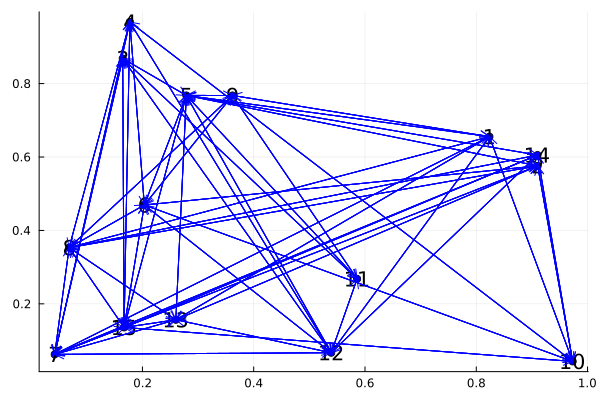

In [30]:
using LinearAlgebra
X = Symmetric(rand(0:1, n, n))
plota_grafo(P, X)


The matrix below represents the nodes and which of them has edges between them.

The diagonal is equal to zero because one node cannot be connected to itself.

Also, the matrix is symmetrical because it is an undirected graph.

In [31]:
using LinearAlgebra

c = round.(Int, value.(X))
c[diagind(c)] .= 0.0
c

15×15 Matrix{Int64}:
 0  0  0  0  1  0  1  1  1  1  0  1  1  0  0
 0  0  0  0  1  1  1  1  0  1  0  0  1  0  0
 0  0  0  0  1  0  1  0  0  0  1  1  0  0  1
 0  0  0  0  0  1  1  1  0  1  0  1  0  0  1
 1  1  1  0  0  1  0  0  1  0  1  1  1  1  1
 0  1  0  1  1  0  0  1  1  1  0  1  0  0  1
 1  1  1  1  0  0  0  1  0  0  0  1  1  1  1
 1  1  0  1  0  1  1  0  1  0  0  0  1  1  1
 1  0  0  0  1  1  0  1  0  0  1  0  0  0  0
 1  1  0  1  0  1  0  0  0  0  0  0  0  1  1
 0  0  1  0  1  0  0  0  1  0  0  1  0  0  0
 1  0  1  1  1  1  1  0  0  0  1  0  1  1  0
 1  1  0  0  1  0  1  1  0  0  0  1  0  0  1
 0  0  0  0  1  0  1  1  0  1  0  1  0  0  1
 0  0  1  1  1  1  1  1  0  1  0  0  1  1  0

   # Optimizing the Problem
   
   The idea is to have two matrixes. The matrix $c$, as shown previously, is the connection of the nodes. So, for example, $c[1,2]$ means that node 1 is connected to 2. There is an edge between them, which means that they cannot simultaneously use the transmission resource. Also, one node cannot be connected to itself.
    
   The other matrix is the $x$. It is a node per time slot matrix. So, $x[3,4]$, for example, means node 3 is in time slot 4.
    
   The problem has two constraints. The first one is:
    
   $\sum_{j=1}^{n} Xij = 1 $
   
   This means that each node can only be used in one time slot.

   The second constraint is  when we have $ c[i,j] = 1 $:
   
   $ x[i,j] + x[k,j] ≤ 1 $
   
   So, for example, $c[1,2]$ means nodes 1 and 2 have an edge between them. Since in the matrix $x$ the lines are the nodes and the columns are the time slots, the lines 1 and 2 can't be filled - have 1 - in the same column because that would mean that these nodes are in the same time slot. Only one of them may use that slot, this is why is minor or equal to 1.

Also, regarding the objective, the goal is to know the minimum number of time slots needed to satisfy all nodes: 

 $ min \sum_{j=1}^{n} y[j] $
 
 So, we want to know how many columns are filled in the matrix $x$. 
    

In [32]:
using JuMP
using LinearAlgebra


# Define the graph as a binary constraint matrix
c = round.(Int, value.(X))
c[diagind(c)] .= 0.0


# Create a model and set solver
m = Model(Cbc.Optimizer)

# Define binary variables for each node and time slot (x[i,j] = 1 if node i is used in time slot j)
@variable(m, x[1:n, 1:n], Bin)

# Define binary variables for each time slot (y[i] = 1 if time slot i is used)
@variable(m, y[1:n], Bin)

# Constrain each node to be used only once (in one time slot only)
@constraint(m, [i in 1:n], sum(x[i,j] for j in 1:n) == 1)

# Avoid interferences between nodes connected by an edge (nodes cannot be used in the same time slot if connected)
for j in 1:n
    for i in 1:n
        for k in 1:n
            if c[i,k] == 1
                @constraint(m, x[i,j] + x[k,j] <= 1)
            end
        end
    end
end

# Connect binary variables x and y (if node i is assigned to time slot j, then time slot 
# j must be used (y[j] = 1), and if time slot j is not used (y[j] = 0), then node i cannot 
# be assigned to time slot j (x[i,j] = 0))
for j in 1:n
    for i in 1:n
        @constraint(m, x[i,j] <= y[j])
    end
end

# Minimize the number of time slots
@objective(m, Min, sum(y[j] for j in 1:n))

# Solve the model
optimize!(m)

# Print the solution
println("Minimum number of time slots: ", round.(Int, objective_value(m)))
println("Solution:")
for i in 1:n, j in 1:n
    if value(x[i,j]) == 1
        println("Node ", i, " uses resource in time slot ", j)
    end
end


Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Jan  1 1970 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 1 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 755 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 781 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 468 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 209 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 110 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 46 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 18 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 2 strengthened rows, 0 substitutions
Cgl0004I processed model has 449 rows, 240 columns (240 integer (240 of which binary)) and 2096 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0045I 15 integer variables out of 240 objects

# Cbc.Optimizer

Using this solver it is possible to see the time the computer needs to find an optimal solution. Being able to check the computation time is especially important in optimization problems. Normally there are many options for optimizing a problem, and the difference usually is the capacity of running the code. Some algorithms are able to work with more inputs in less time. 

In our case, for n = 5, the total time (CPU seconds) was 0.02s. And, for n = 15, the time was 1.89s. For values much bigger, such as n = 50, the computer wasn't able to run it.


## Conclusion

Testing the code for many examples it is possible to verify that it works correctly. Although, for really big quantities of nodes, the computer starts to have difficulties running it. There are probably other approaches to improve that.

Despite this, the program completes its goal and gives the minimum number of time slots needed to satisfy all nodes.